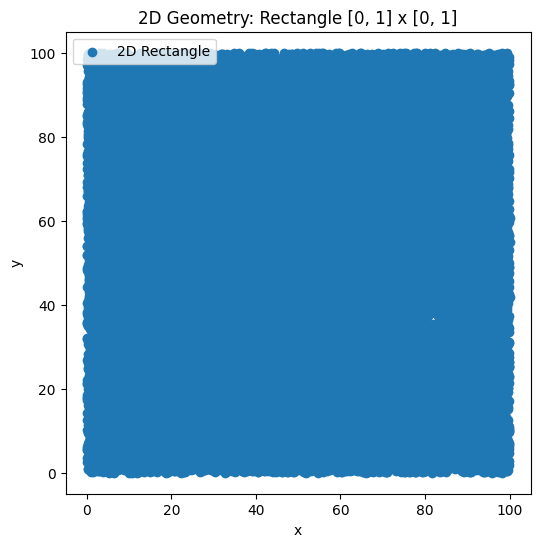

Compiling model...
Building feed-forward neural network...
'build' took 0.049000 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.720735 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [0.00e+00, 0.00e+00, 1.71e+16, 7.30e+02, 5.85e+02]    [0.00e+00, 0.00e+00, 1.95e+16, 7.30e+02, 5.85e+02]    []  
1000      [0.00e+00, 0.00e+00, 8.05e+13, 3.44e+01, 1.76e+02]    [0.00e+00, 0.00e+00, 7.49e+13, 3.44e+01, 1.76e+02]    []  
2000      [0.00e+00, 0.00e+00, 4.05e+13, 1.08e+01, 9.02e+01]    [0.00e+00, 0.00e+00, 4.00e+13, 1.08e+01, 9.02e+01]    []  
3000      [0.00e+00, 0.00e+00, 1.16e+13, 5.06e+01, 5.64e+00]    [0.00e+00, 0.00e+00, 8.56e+12, 5.06e+01, 5.64e+00]    []  
4000      [0.00e+00, 0.00e+00, 5.59e+12, 5.34e+01, 1.61e+01]    [0.00e+00, 0.00e+00, 4.28e+12, 5.34e+01, 1.61e+01]    []  
5000      [0.00e+00, 0.00e+00, 5.79e+12, 1.95e+00, 6.39e-01]    [0.00e+00, 0.00e+00, 5.49e+12, 1.95e+00, 6.39e-01]    []  
6000      [0.00e+00, 0.00e+00, 5.36e+12, 8.32e+00, 4.25e-01]    [0.00e+00, 0.00e+00, 4

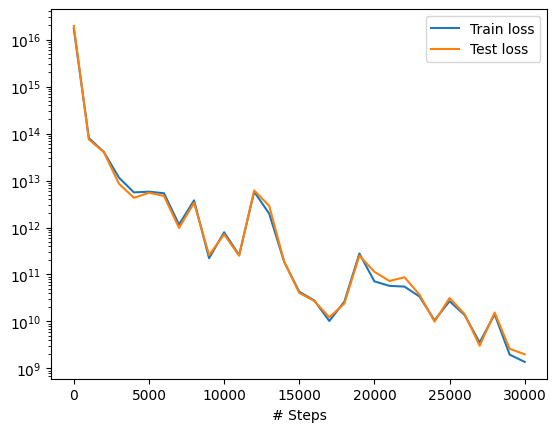

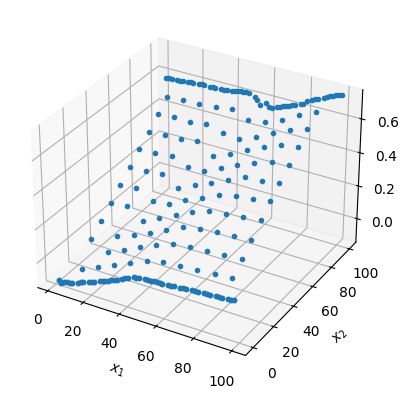

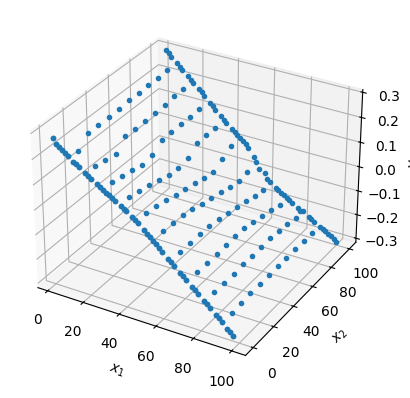

In [14]:
# Code-1.
# This code uses the continuous approach for the PDE definition. The displacement deriving the stress. Andall values are not normalised.
# The result respects the boundary condition but the plate is twisted, which is not like a pure membrane defromation. 
# Code-2 tested the descrete method.
import pandas as pd
import os
import tensorflow as tf

os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

traction=1e5 
E=2e8
L =100 # mm
nu=0.3
qx=0
qy=0
square = dde.geometry.Rectangle([0, 0], [L, L])
geom = square


# Sample points in the geometry
Samp = geom.random_points(30000)

# Visualize the geometry
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)
def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)



def traction_top(x, y,X):
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u_x/∂x
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u_x/∂y
    duydx = dde.grad.jacobian(y, x, i=1, j=0)  # ∂u_y/∂x
    duydy = dde.grad.jacobian(y, x, i=1, j=1)  # ∂u_y/∂y

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on top boundary
    T_x = sigma_xy  # Since n_x = 0, T_x = σ_xy n_y
    T_y = sigma_yy  # Since n_y = 1, T_y = σ_yy n_y

    # Desired traction
    T_x_desired = 0
    T_y_desired = traction  # 1e5 Pa
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired    

    return T_x_residual, T_y_residual


bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma=dde.OperatorBC(geom, traction_top, boundary_top)


def pde(x, y):
    
    duxdx=dde.grad.jacobian(y,x,i=0,j=0)
    duxdy=dde.grad.jacobian(y,x,i=0,j=1)
    duydx=dde.grad.jacobian(y,x,i=1,j=0)
    duydy=dde.grad.jacobian(y,x,i=1,j=1)
    #Strain
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Constitutive relations residuals
    sigma_xx = (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy
    
    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0)
    sigma_xy_y = dde.grad.jacobian(sigma_xy, x, i=0, j=1)
    sigma_xy_x = dde.grad.jacobian(sigma_xy, x, i=0, j=0)
    sigma_yy_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    
    return [eq1, eq2]

data = dde.data.PDE(
    geom,
    pde, [bc_top_sigma, bc_bottom_u_x, bc_bottom_u_y],
    num_domain=300,
    num_boundary=200,
    num_test=100,
    )

# Network for C_L
layer_size = [2] + [62] * 5 + [2]  
activation = "relu"
initializer = "He normal"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)

model= dde.Model(data, net_C_L)

model.compile("adam", lr=1e-4)
# Define the model with the PDE, initial and boundary conditions

# Add the callback when training the model
losshistory, train_state = model.train(epochs=30000, display_every=1000)

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [17]:
# Code-2.
# This code minimise the parameter values but remain the same ratio. The PDE definition is based on descrete method, unlike Code-1. There are six equation. 
# The structure tested the result when increase layers instead of  nuons.
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import torch

# Constants
traction = 0.1
E = 2e2
L = 1  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and x[1]==0

def boundary_top(x, on_boundary):
    return on_boundary and x[1]==L

# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, lambda x: traction, boundary_top, component=3)


# Define the PDE
def pde(x, y):
    sigma_xx=y[:,2:3]
    sigma_yy=y[:,3:4]
    sigma_xy=y[:,4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy
    d2eps_xx_dy2 = dde.grad.hessian(eps_xx, x, component=0, i=1, j=1)
    d2eps_yy_dx2 =  dde.grad.hessian(eps_yy, x, component=0, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.hessian(gamma_xy, x, component=0,i=0, j=1)

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    
    return [eq1,eq2,eq3,eq4,eq5,eq6]

# Data definition
data = dde.data.PDE(
    geom,
    pde,
    [
        bc_bottom_u_x,
        bc_bottom_u_y,
        bc_top_sigma_yy
    ],
    num_domain=400,
    num_boundary=400,
    num_test=400,
)

# Neural network
net = dde.maps.FNN([2] + [30] * 10 + [5], "relu", "He normal")

# Model
model = dde.Model(data, net)

# Compile the model with adjusted loss weights
model.compile("adam",lr=1e-5)

# Train the model
losshistory, train_state = model.train(epochs=60000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
Building feed-forward neural network...
'build' took 0.133922 s



SystemError: D:\a\1\s\Objects\listobject.c:338: bad argument to internal function

Compiling model...
Building feed-forward neural network...
'build' took 0.049688 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.680525 s

Training model...

0         [2.49e-02, 8.87e-03, 5.68e+02, 6.43e+02, 1.10e+02, 5.14e-01, 2.84e+00, 3.27e-02, 1.43e-01, 4.30e-01]    [2.49e-02, 8.87e-03, 5.68e+02, 6.43e+02, 1.10e+02, 5.14e-01, 2.84e+00, 3.27e-02, 1.43e-01, 4.30e-01]    []  
1000      [2.66e-02, 7.28e-03, 2.27e+02, 2.75e+02, 7.92e+01, 3.77e-01, 3.21e+00, 3.86e-02, 1.36e-01, 4.61e-01]    [2.66e-02, 7.28e-03, 2.27e+02, 2.75e+02, 7.92e+01, 3.77e-01, 3.21e+00, 3.86e-02, 1.36e-01, 4.61e-01]    []  
Resampled data at epoch 1000
First 5 x_observe values after resampling:
[[77 39]
 [91 79]
 [28 28]
 [50 94]
 [15  2]]
First 5 sigma_xx_observe values after resampling:
[[ 0.00188638]
 [-0.00011915]
 [ 0.00606636]
 [-0.00162446]
 [ 0.026078  ]]
First 5 sigma_yy_observe values after resampling:
[[0.10095  ]
 [0.0993731]
 [0.101337 ]
 [0.100069 ]
 [0.0982644]]
2000      [2.67e-02, 6.78e-03, 1.19e+02, 1.62e+02, 5.63e+01, 3.02e-01, 3.21e+00, 3.31e-02, 1.26e-01, 4.31e-01]    [2.67e-02, 6.78e-03, 1.19e+02, 1.6

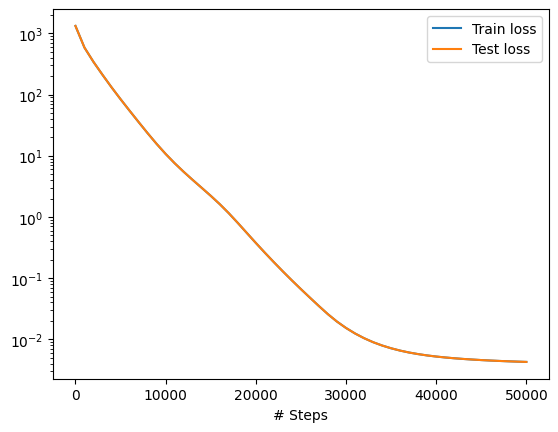

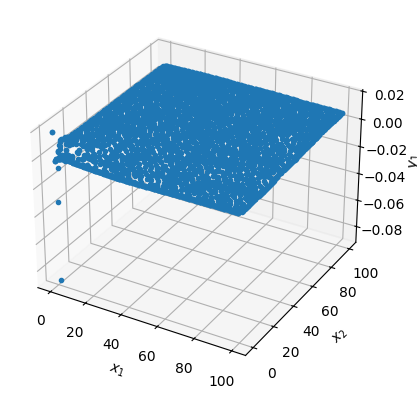

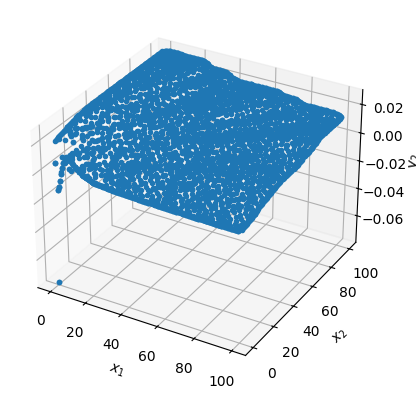

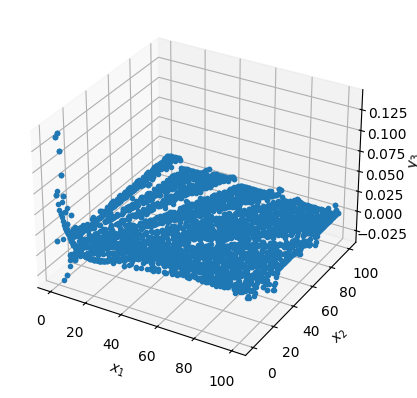

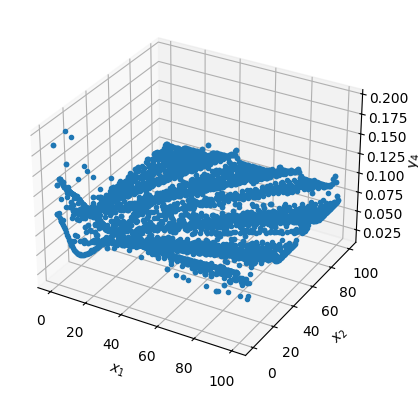

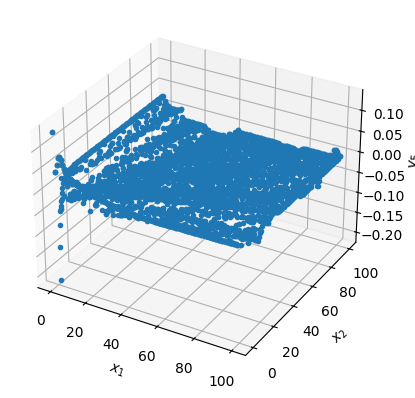

In [32]:
# Code-3. 
# This code tried a new approach. Instead of feeding a large fixed data. the data being resampled every 1000 epoch. 
# To make the code more efficient, the network structure complexity is reduced and the comtinuity equation is removed.
# The result still shows a weird result that the pinned edge deform larger due to the higher stress instead of the pinned condition.
# A new implemetation is in the Code-6.
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from deepxde.icbc import PointSetBC

# Constants
traction = 0.1
E = 2e2
L = 100  # mm
nu = 0.3
qx = 0
qy = 0
fraction=0.1
# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)
def func(x):
    return 0
def func2(x):
    return traction 
# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, func, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, func, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, func2 , boundary_top, component=3)

# Read the entire Excel file
data_observe = pd.read_excel('S11.xlsx')  # Replace 'Stress.xlsx' with your actual file name

# Take only 10% of the data
data_observe_sample = data_observe.sample(frac=fraction)  # random_state for reproducibility

# Extract the desired columns and convert to numpy arrays
x_observe = data_observe_sample[['X', 'Y']].values  # Shape (N, 2)
#print(x_observe)

sigma_xx_observe = data_observe_sample['S11'].values.reshape(-1, 1)  # Shape (N, 1)
sigma_yy_observe = data_observe_sample['S22'].values.reshape(-1, 1)
#sigma_xy_observe = data_observe_sample['S.S12'].values.reshape(-1, 1)

#print(sigma_xx_observe)

# Create PointSet and PointSetBCs

sigma_xx_bc = dde.PointSetBC(x_observe, sigma_xx_observe, component=2)
sigma_yy_bc = dde.PointSetBC(x_observe, sigma_yy_observe, component=3)
#sigma_xy_bc = dde.PointSetBC(x_observe, sigma_xy_observe, component=4)

class ResampleCallback(dde.callbacks.Callback):
    def __init__(self, data_observe, fraction, sigma_xx_bc, sigma_yy_bc, resample_every):
        super().__init__()
        self.data_observe = data_observe
        self.fraction = fraction
        self.sigma_xx_bc = sigma_xx_bc
        self.sigma_yy_bc = sigma_yy_bc
        self.resample_every = resample_every  # Resample interval in epochs
        self.epoch_counter = 0  # Initialize the epoch counter

    def on_epoch_end(self):
        self.epoch_counter += 1  # Increment epoch counter
        if self.epoch_counter % self.resample_every == 0:
            # Resample data
            data_observe_sample = self.data_observe.sample(frac=self.fraction)
            x_observe = data_observe_sample[['X', 'Y']].values  # Shape (N, 2)
            sigma_xx_observe = data_observe_sample['S11'].values.reshape(-1, 1)
            sigma_yy_observe = data_observe_sample['S22'].values.reshape(-1, 1)

            self.sigma_xx_bc = dde.PointSetBC(x_observe, sigma_xx_observe, component=2)
            self.sigma_yy_bc = dde.PointSetBC(x_observe, sigma_yy_observe, component=3)

            # Update training points
            self.model

            print(f"Resampled data at epoch {self.epoch_counter}")
            print("First 5 x_observe values after resampling:")
            print(x_observe[:5])
            print("First 5 sigma_xx_observe values after resampling:")
            print(sigma_xx_observe[:5])
            print("First 5 sigma_yy_observe values after resampling:")
            print(sigma_yy_observe[:5])

       

# Define the PDE
def pde(x, y):
    sigma_xx = y[:, 2:3]
    sigma_yy = y[:, 3:4]
    sigma_xy = y[:, 4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    
    return [eq1, eq2,eq4,eq5,eq6]

data = dde.data.PDE(
    geom,
    pde,
    [bc_bottom_u_x,
    bc_bottom_u_y,
    bc_top_sigma_yy,
    sigma_xx_bc,
    sigma_yy_bc
    ],
    num_domain=1500,
    num_boundary=500
)

# Neural network
net = dde.maps.FNN([2] + [64] * 5 + [5], "tanh", "He normal")

# Model
model = dde.Model(data, net)

# Compile the model
model.compile("adam", lr=1e-6)

resample_callback = ResampleCallback(data_observe, fraction, sigma_xx_bc, sigma_yy_bc,1000)

# Train the model with the callback
losshistory, train_state = model.train(epochs=50000, callbacks=[resample_callback],display_every=1000)
# Train the model
#losshistory, train_state = model.train(epochs=50000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


[[85 50]
 [43 78]
 [77 10]
 ...
 [79 93]
 [81 45]
 [89 13]]
[[ 0.00019102]
 [-0.00073765]
 [ 0.0172978 ]
 ...
 [-0.00066545]
 [ 0.00070093]
 [ 0.00717859]]
Compiling model...
Building feed-forward neural network...
'build' took 0.046608 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.797224 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [0.00e+00, 0.00e+00, 8.15e+02, 1.99e+02, 1.49e+03, 3.57e+03, 6.72e+02]    [0.00e+00, 0.00e+00, 8.15e+02, 1.99e+02, 1.49e+03, 3.57e+03, 6.72e+02]    []  
1000      [0.00e+00, 0.00e+00, 3.36e+01, 4.20e-01, 1.24e+01, 4.84e+02, 4.53e+01]    [0.00e+00, 0.00e+00, 3.36e+01, 4.20e-01, 1.24e+01, 4.84e+02, 4.53e+01]    []  
2000      [0.00e+00, 0.00e+00, 2.56e-01, 6.09e-02, 4.50e+00, 9.70e+01, 1.08e+01]    [0.00e+00, 0.00e+00, 2.56e-01, 6.09e-02, 4.50e+00, 9.70e+01, 1.08e+01]    []  
3000      [0.00e+00, 0.00e+00, 6.42e-04, 1.83e-02, 1.70e+00, 1.44e+01, 3.83e+00]    [0.00e+00, 0.00e+00, 6.42e-04, 1.83e-02, 1.70e+00, 1.44e+01, 3.83e+00]    []  
4000      [0.00e+00, 0.00e+00, 5.18e-04, 7.12e-03, 7.46e-01, 2.84e+00, 1.33e+00]    [0.00e+00, 0.00e+00, 5.18e-04, 7.12e-03, 7.46e-0

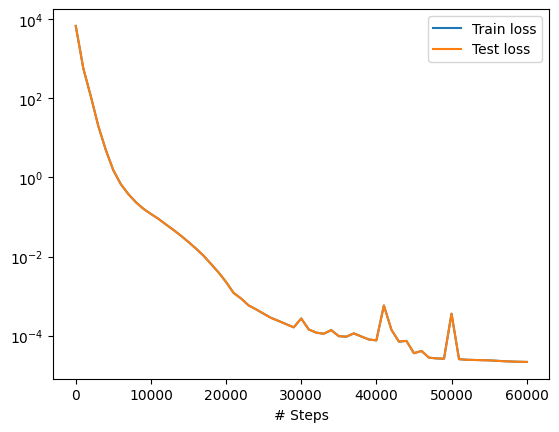

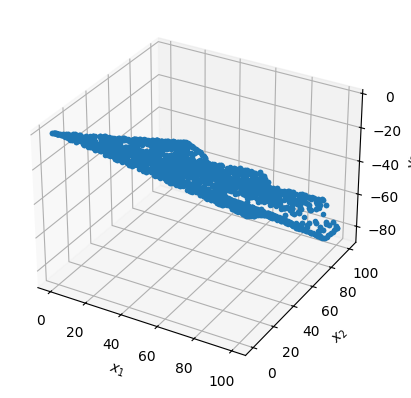

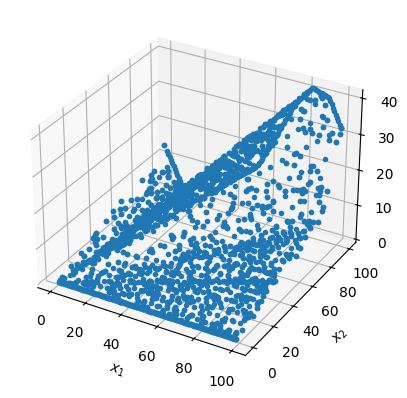

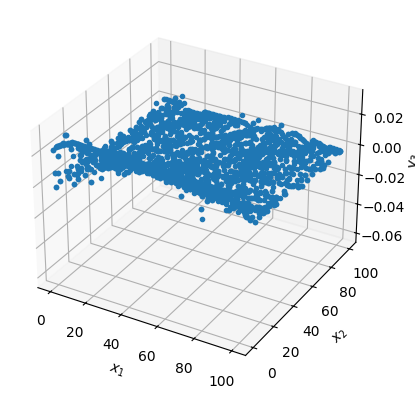

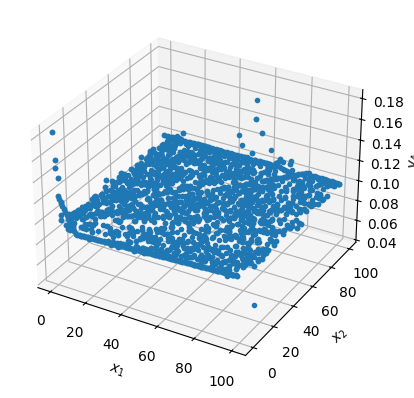

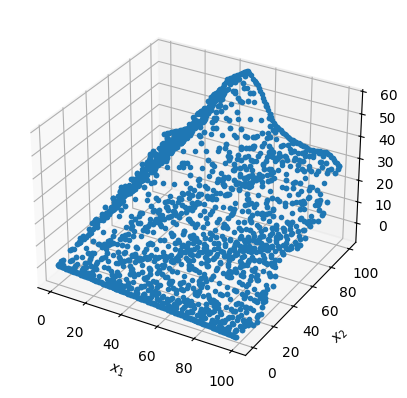

In [7]:
# Code-4.
# This code aims to improve the accuracy by feeding some sample data and coupled with Relu. 
# The equation of displaceemnt is removed to test the prediction of deformation without any direct connections between strain and stress.
# The result shows the code follow the boundary condition but displacement is not realistic. And the stress learning was not accurarte.
# The Code-5 tests when implemeting the whole equations. 
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from deepxde.icbc import PointSetBC

# Constants
traction = 0.1
E = 2e2
L = 100  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)
def func(x):
    return 0
def func2(x):
    return traction 
# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, func, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, func, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, func2 , boundary_top, component=3)

# Read the entire Excel file
data_observe = pd.read_excel('S11.xlsx')  # Replace 'Stress.xlsx' with your actual file name

# Take only 10% of the data
data_observe_sample = data_observe.sample(frac=0.1, random_state=42)  # random_state for reproducibility

# Extract the desired columns and convert to numpy arrays
x_observe = data_observe_sample[['X', 'Y']].values  # Shape (N, 2)
print(x_observe)

sigma_xx_observe = data_observe_sample['S11'].values.reshape(-1, 1)  # Shape (N, 1)
sigma_yy_observe = data_observe_sample['S22'].values.reshape(-1, 1)
#sigma_xy_observe = data_observe_sample['S.S12'].values.reshape(-1, 1)

print(sigma_xx_observe)

# Create PointSet and PointSetBCs

sigma_xx_bc = dde.PointSetBC(x_observe, sigma_xx_observe, component=2)
sigma_yy_bc = dde.PointSetBC(x_observe, sigma_yy_observe, component=3)
#sigma_xy_bc = dde.PointSetBC(x_observe, sigma_xy_observe, component=4)

# Define the PDE
def pde(x, y):
    ux = y[:, 0:1]
    uy = y[:, 1:2]

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx
   
    d2eps_xx_dy2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2eps_yy_dx2 = dde.grad.hessian(y, x, component=1, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.jacobian(gamma_xy, x, i=0, j=1)
    # Stress components
    sigma_xx = (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0)
    sigma_xy_y = dde.grad.jacobian(sigma_xy, x, i=0, j=1)
    sigma_xy_x = dde.grad.jacobian(sigma_xy, x, i=0, j=0)
    sigma_yy_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1)

    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    return [eq1, eq2]

data = dde.data.PDE(
    geom,
    pde,
    [bc_bottom_u_x,
    bc_bottom_u_y,
    bc_top_sigma_yy,
    sigma_xx_bc,
    sigma_yy_bc
    ],
    num_domain=1000,
    num_boundary=500,
    num_test=500
)

# Neural network
net = dde.maps.FNN([2] + [32] * 5 + [5], "relu", "He normal")

# Model
model = dde.Model(data, net)

# Compile the model
model.compile("adam", lr=1e-5)

# Train the model
losshistory, train_state = model.train(epochs=60000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)




In [8]:
# Code-5.
# Continue from the Code-4. This time the whole 6 equations are given coupled with the data.
#
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Constants
traction = 0.1
E = 2e2
L = 100  # mm
nu = 0.3
qx = 0
qy = 0

# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)

# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, lambda x: traction, boundary_top, component=3)


# Read observation data
data_observe = pd.read_excel('Stress.xlsx')  # Replace 'data.xlsx' with your actual file name
x_observe = data_observe[['X', 'Y']].values  # Shape (N, 2)
print(x_observe)
sigma_xx_observe = data_observe['S.S11'].values.reshape(-1, 1)  # Shape (N, 1)
sigma_yy_observe = data_observe['S.S22'].values.reshape(-1, 1)
sigma_xy_observe = data_observe['S.S12'].values.reshape(-1, 1)


# Combine the observed stress components into a single array
y_observe = np.hstack([sigma_xx_observe, sigma_yy_observe, sigma_xy_observe])

# Define the PDE
def pde(x, y):
    sigma_xx = y[:, 2:3]
    sigma_yy = y[:, 3:4]
    sigma_xy = y[:, 4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy
    d2eps_xx_dy2 = dde.grad.hessian(eps_xx, x, component=0, i=1, j=1)
    d2eps_yy_dx2 = dde.grad.hessian(eps_yy, x, component=0, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.hessian(gamma_xy, x, component=0, i=0, j=1)

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    
    return [eq1, eq2, eq3, eq4, eq5, eq6]

# Data definition with observations
data = dde.data.PDE(
    geom,
    pde,
    bcs=[
        bc_bottom_u_x,
        bc_bottom_u_y,
        bc_top_sigma_yy,
    ],
    num_domain=400,
    num_boundary=400,
    num_test=400,
    anchors=x_observe,
)

# Neural network
net = dde.maps.FNN([2] + [30] * 10 + [5], "relu", "He normal")

# Model
model = dde.Model(data, net)


# Compile the model
model.compile("adam", lr=1e-5)
# Train the model
losshistory, train_state = model.train(epochs=60000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


FileNotFoundError: [Errno 2] No such file or directory: 'Stress.xlsx'

Compiling model...
Building feed-forward neural network...
'build' took 0.048021 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.626868 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [1.15e-02, 5.79e-03, 1.19e+02, 3.64e+02, 3.22e+01, 1.07e-01, 2.40e-01, 1.21e-01, 1.69e-01, 7.76e-02]    [1.15e-02, 5.79e-03, 1.19e+02, 3.64e+02, 3.22e+01, 1.07e-01, 2.40e-01, 1.21e-01, 1.69e-01, 7.76e-02]    []  
1000      [1.04e-02, 5.89e-03, 5.69e+01, 1.19e+02, 2.26e+01, 5.91e-02, 3.19e-01, 1.25e-01, 1.70e-01, 8.98e-02]    [1.04e-02, 5.89e-03, 5.69e+01, 1.19e+02, 2.26e+01, 5.91e-02, 3.19e-01, 1.25e-01, 1.70e-01, 8.98e-02]    []  
Resampled data at epoch 1000
First 5 x_observe values after resampling:
[[29 84]
 [ 3 36]
 [83 36]
 [68 20]
 [88 81]]
First 5 sigma_xx_observe values after resampling:
[[-7.35268e-04]
 [ 3.81667e-05]
 [ 1.44662e-03]
 [ 1.13943e-02]
 [-2.05568e-04]]
First 5 sigma_yy_observe valu

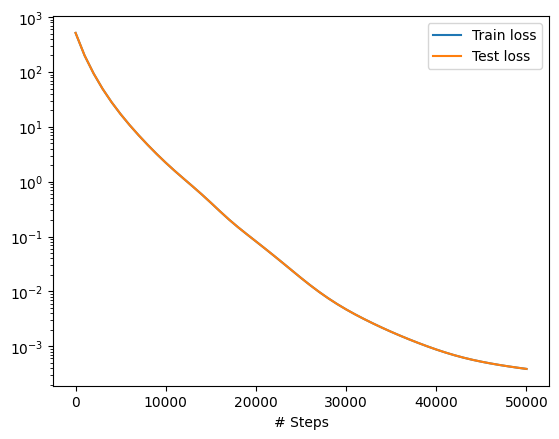

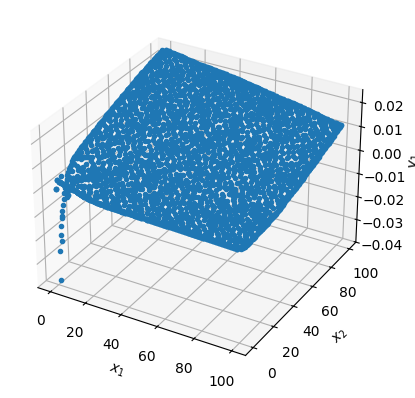

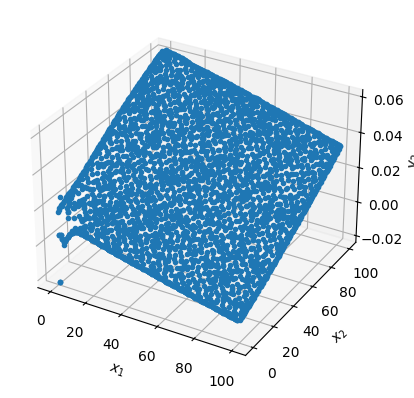

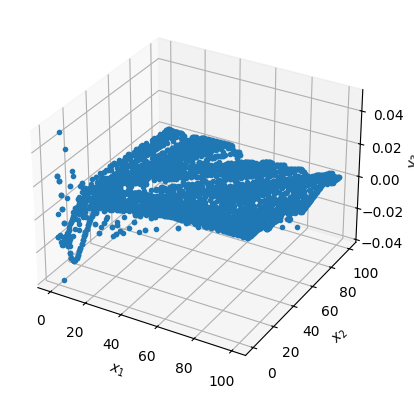

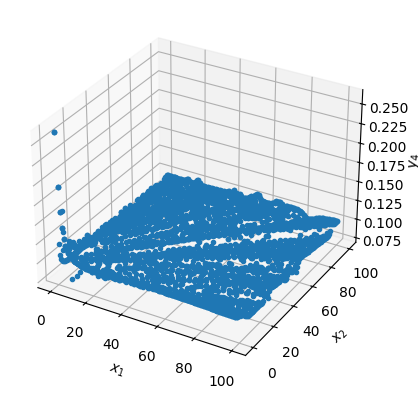

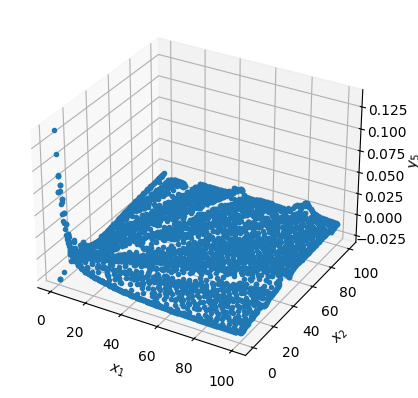

In [6]:
# Code-6. 
# This code meant for testing the enfroced boundary condition. From the Code-3, the observation shows the concentration stress at the bottom caused the plate deflect more instead of more fixed
# Either change the equlibrium equations or implement more constraint equations
# The boundary condition is more enforced here

import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from deepxde.icbc import PointSetBC

# Constants
traction = 0.1
E = 2e2
L = 100  # mm
nu = 0.3
qx = 0
qy = 0
fraction=0.1
# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)
def func(x):
    return 0
def func2(x):
    return traction 
# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, func, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, func, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, func2 , boundary_top, component=3)

# Read the entire Excel file
data_observe = pd.read_excel('S11.xlsx')  # Replace 'Stress.xlsx' with your actual file name

# Take only 10% of the data
data_observe_sample = data_observe.sample(frac=fraction)  # random_state for reproducibility

# Extract the desired columns and convert to numpy arrays
x_observe = data_observe_sample[['X', 'Y']].values  # Shape (N, 2)
#print(x_observe)

sigma_xx_observe = data_observe_sample['S11'].values.reshape(-1, 1)  # Shape (N, 1)
sigma_yy_observe = data_observe_sample['S22'].values.reshape(-1, 1)
#sigma_xy_observe = data_observe_sample['S.S12'].values.reshape(-1, 1)

#print(sigma_xx_observe)

# Create PointSet and PointSetBCs

sigma_xx_bc = dde.PointSetBC(x_observe, sigma_xx_observe, component=2)
sigma_yy_bc = dde.PointSetBC(x_observe, sigma_yy_observe, component=3)
#sigma_xy_bc = dde.PointSetBC(x_observe, sigma_xy_observe, component=4)

class ResampleCallback(dde.callbacks.Callback):
    def __init__(self, data_observe, fraction, sigma_xx_bc, sigma_yy_bc, resample_every):
        super().__init__()
        self.data_observe = data_observe
        self.fraction = fraction
        self.sigma_xx_bc = sigma_xx_bc
        self.sigma_yy_bc = sigma_yy_bc
        self.resample_every = resample_every  # Resample interval in epochs
        self.epoch_counter = 0  # Initialize the epoch counter

    def on_epoch_end(self):
        self.epoch_counter += 1  # Increment epoch counter
        if self.epoch_counter % self.resample_every == 0:
            # Resample data
            data_observe_sample = self.data_observe.sample(frac=self.fraction)
            x_observe = data_observe_sample[['X', 'Y']].values  # Shape (N, 2)
            sigma_xx_observe = data_observe_sample['S11'].values.reshape(-1, 1)
            sigma_yy_observe = data_observe_sample['S22'].values.reshape(-1, 1)

            self.sigma_xx_bc = dde.PointSetBC(x_observe, sigma_xx_observe, component=2)
            self.sigma_yy_bc = dde.PointSetBC(x_observe, sigma_yy_observe, component=3)

            # Update training points
            self.model

            print(f"Resampled data at epoch {self.epoch_counter}")
            print("First 5 x_observe values after resampling:")
            print(x_observe[:5])
            print("First 5 sigma_xx_observe values after resampling:")
            print(sigma_xx_observe[:5])
            print("First 5 sigma_yy_observe values after resampling:")
            print(sigma_yy_observe[:5])

       

# Define the PDE
def pde(x, y):
    sigma_xx = y[:, 2:3]
    sigma_yy = y[:, 3:4]
    sigma_xy = y[:, 4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    
    return [eq1, eq2,eq4,eq5,eq6]

data = dde.data.PDE(
    geom,
    pde,
    [bc_bottom_u_x,
    bc_bottom_u_y,
    bc_top_sigma_yy,
    sigma_xx_bc,
    sigma_yy_bc
    ],
    num_domain=1500,
    num_boundary=500
)

# Neural network
net = dde.maps.FNN([2] + [64] * 5 + [5], "tanh", "He normal")

# Model
model = dde.Model(data, net)

# Adjust the loss weights
#pde_weights = [1, 1, 100, 100, 100]
model.compile("adam", lr=1e-6)

# Enforce boundary conditions exactly
def boundary_transform(x, y_nn):
    u_x_nn, u_y_nn = y_nn[:, 0:1], y_nn[:, 1:2]
    u_x = x[:, 1:2] / L * u_x_nn  # u_x = 0 at y=0
    u_y = x[:, 1:2] / L * u_y_nn  # u_y = 0 at y=0
    return tf.concat([u_x, u_y, y_nn[:, 2:]], axis=1)

net.apply_output_transform(boundary_transform)


resample_callback = ResampleCallback(data_observe, fraction, sigma_xx_bc, sigma_yy_bc,1000)

# Train the model with the callback
losshistory, train_state = model.train(epochs=50000, callbacks=[resample_callback],display_every=1000)
# Train the model
#losshistory, train_state = model.train(epochs=50000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.078904 s


'compile' took 4.801639 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [1.23e-02, 1.63e-02, 2.73e+02, 5.97e+02, 9.68e+01, 5.06e-02, 4.13e-02, 2.67e-03, 6.58e-03, 2.14e+00, 8.49e-01, 1.54e+00]    [1.23e-02, 1.63e-02, 2.73e+02, 5.97e+02, 9.68e+01, 5.06e-02, 4.13e-02, 2.67e-03, 6.58e-03, 2.14e+00, 8.49e-01, 1.54e+00]    []  
1000      [1.15e-02, 1.46e-02, 1.38e+02, 2.88e+02, 7.08e+01, 4.87e-02, 2.87e-02, 4.75e-03, 5.76e-02, 2.08e+00, 9.07e-01, 1.46e+00]    [1.15e-02, 1.46e-02, 1.38e+02, 2.88e+02, 7.08e+01, 4.87e-02, 2.87e-02, 4.75e-03, 5.76e-02, 2.08e+00, 9.07e-01, 1.46e

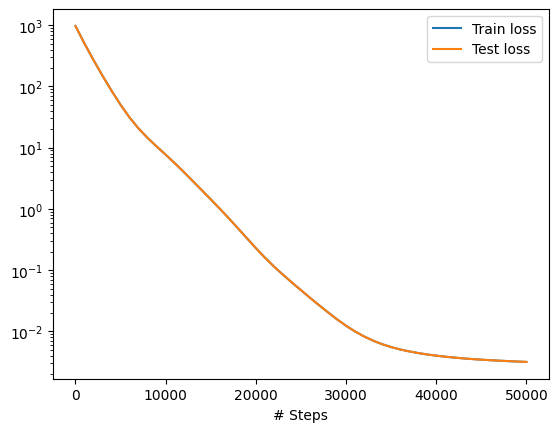

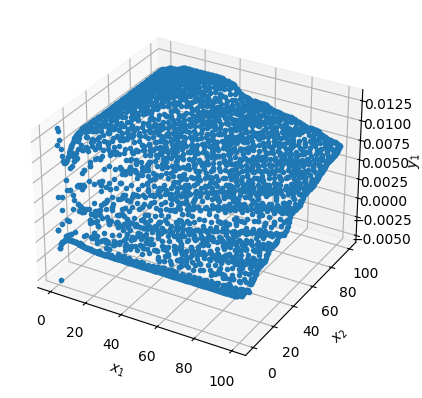

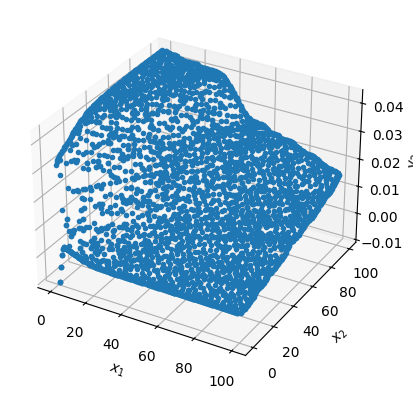

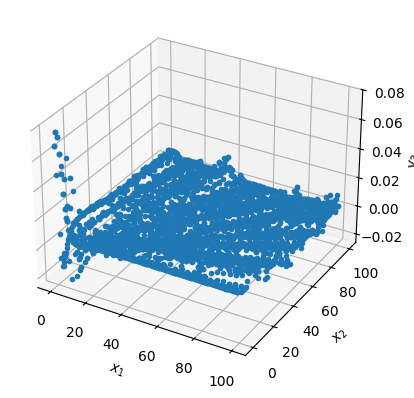

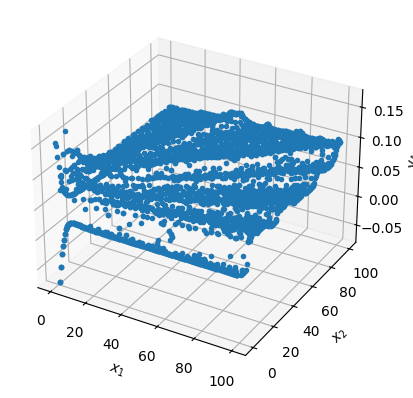

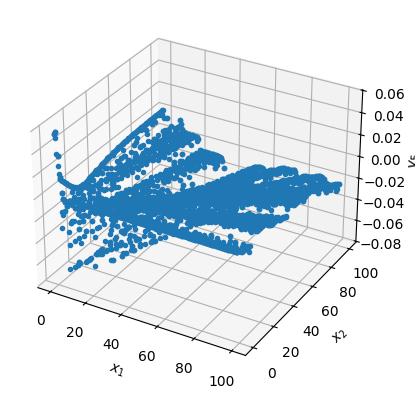

In [1]:
# Code-7. 
# implemeting the laplacien to ensure connectivity


import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from deepxde.icbc import PointSetBC

# Constants
traction = 0.1
E = 2e2
L = 100  # mm
nu = 0.3
qx = 0
qy = 0
fraction=0.1
# Geometry
geom = dde.geometry.Rectangle([0, 0], [L, L])

# Boundary definitions
def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)
def func(x):
    return 0
def func2(x):
    return traction 
# Bottom boundary conditions
bc_bottom_u_x = dde.DirichletBC(geom, func, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, func, boundary_bottom, component=1)
bc_top_sigma_yy = dde.DirichletBC(geom, func2 , boundary_top, component=3)

# Read the entire Excel file
data_observe = pd.read_excel('S11.xlsx')  # Replace 'Stress.xlsx' with your actual file name

# Take only 10% of the data
data_observe_sample = data_observe.sample(frac=fraction)  # random_state for reproducibility

# Extract the desired columns and convert to numpy arrays
x_observe = data_observe_sample[['X', 'Y']].values  # Shape (N, 2)
#print(x_observe)

sigma_xx_observe = data_observe_sample['S11'].values.reshape(-1, 1)  # Shape (N, 1)
sigma_yy_observe = data_observe_sample['S22'].values.reshape(-1, 1)
#sigma_xy_observe = data_observe_sample['S.S12'].values.reshape(-1, 1)

#print(sigma_xx_observe)

# Create PointSet and PointSetBCs

sigma_xx_bc = dde.PointSetBC(x_observe, sigma_xx_observe, component=2)
sigma_yy_bc = dde.PointSetBC(x_observe, sigma_yy_observe, component=3)
#sigma_xy_bc = dde.PointSetBC(x_observe, sigma_xy_observe, component=4)

class ResampleCallback(dde.callbacks.Callback):
    def __init__(self, data_observe, fraction, sigma_xx_bc, sigma_yy_bc, resample_every):
        super().__init__()
        self.data_observe = data_observe
        self.fraction = fraction
        self.sigma_xx_bc = sigma_xx_bc
        self.sigma_yy_bc = sigma_yy_bc
        self.resample_every = resample_every  # Resample interval in epochs
        self.epoch_counter = 0  # Initialize the epoch counter

    def on_epoch_end(self):
        self.epoch_counter += 1  # Increment epoch counter
        if self.epoch_counter % self.resample_every == 0:
            # Resample data
            data_observe_sample = self.data_observe.sample(frac=self.fraction)
            x_observe = data_observe_sample[['X', 'Y']].values  # Shape (N, 2)
            sigma_xx_observe = data_observe_sample['S11'].values.reshape(-1, 1)
            sigma_yy_observe = data_observe_sample['S22'].values.reshape(-1, 1)

            self.sigma_xx_bc = dde.PointSetBC(x_observe, sigma_xx_observe, component=2)
            self.sigma_yy_bc = dde.PointSetBC(x_observe, sigma_yy_observe, component=3)

            # Update training points
            self.model

            print(f"Resampled data at epoch {self.epoch_counter}")
            print("First 5 x_observe values after resampling:")
            print(x_observe[:5])
            print("First 5 sigma_xx_observe values after resampling:")
            print(sigma_xx_observe[:5])
            print("First 5 sigma_yy_observe values after resampling:")
            print(sigma_yy_observe[:5])

       

# Define the PDE
def pde(x, y):
    sigma_xx = y[:, 2:3]
    sigma_yy = y[:, 3:4]
    sigma_xy = y[:, 4:5]
    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)
    duydx = dde.grad.jacobian(y, x, i=1, j=0)
    duydy = dde.grad.jacobian(y, x, i=1, j=1)

    # Strain components
    gamma_xy = duxdy + duydx
    eps_xx = duxdx
    eps_yy = duydy

    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(y, x, i=2, j=0)
    sigma_xy_y = dde.grad.jacobian(y, x, i=4, j=1)
    sigma_xy_x = dde.grad.jacobian(y, x, i=4, j=0)
    sigma_yy_y = dde.grad.jacobian(y, x, i=3, j=1)
    
    d2sigma_xx_dy2 = dde.grad.hessian(y, x, component=2, i=1, j=1)
    d2sigma_yy_dx2 = dde.grad.hessian(y, x, component=3, i=0, j=0)
    d2sigma_xy_dxdy = dde.grad.hessian(y, x, component=4, i=0, j=1)

    d2eps_xx_dy2 = dde.grad.hessian(eps_xx, x, component=0, i=1, j=1)
    d2eps_yy_dx2 = dde.grad.hessian(eps_yy, x, component=0, i=0, j=0)
    d2eps_xy_dxdy = dde.grad.hessian(gamma_xy, x, component=0, i=0, j=1)

    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    eq4 = sigma_xx - (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    eq5 = sigma_yy - (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    eq6 = sigma_xy - (E / (2 * (1 + nu))) * gamma_xy
    eq3 = d2eps_xx_dy2 + d2eps_yy_dx2 - 2 * d2eps_xy_dxdy
    eq7 = d2sigma_xx_dy2 + d2sigma_yy_dx2 - 2 * d2sigma_xy_dxdy
    
    return [eq1, eq2,eq4,eq5,eq6,eq7,eq3]

data = dde.data.PDE(
    geom,
    pde,
    [bc_bottom_u_x,
    bc_bottom_u_y,
    bc_top_sigma_yy,
    sigma_xx_bc,
    sigma_yy_bc
    ],
    num_domain=1500,
    num_boundary=500
)

# Neural network
net = dde.maps.FNN([2] + [64] * 5 + [5], "tanh", "He normal")

# Model
model = dde.Model(data, net)

# Adjust the loss weights
#pde_weights = [1, 1, 100, 100, 100]
model.compile("adam", lr=1e-6)

# Enforce boundary conditions exactly
def boundary_transform(x, y_nn):
    u_x_nn, u_y_nn = y_nn[:, 0:1], y_nn[:, 1:2]
    u_x = x[:, 1:2] / L * u_x_nn  # u_x = 0 at y=0
    u_y = x[:, 1:2] / L * u_y_nn  # u_y = 0 at y=0
    return tf.concat([u_x, u_y, y_nn[:, 2:]], axis=1)

net.apply_output_transform(boundary_transform)


resample_callback = ResampleCallback(data_observe, fraction, sigma_xx_bc, sigma_yy_bc,1000)

# Train the model with the callback
losshistory, train_state = model.train(epochs=50000, callbacks=[resample_callback],display_every=1000)
# Train the model
#losshistory, train_state = model.train(epochs=50000, display_every=1000)

# Plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
Building feed-forward neural network...
'build' took 0.043543 s

'compile' took 0.532873 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.38e-01, 1.63e+00]    [1.38e-01, 1.63e+00]    []  
1000      [1.33e-03, 3.40e-02]    [1.33e-03, 3.40e-02]    []  
2000      [8.34e-04, 5.15e-03]    [8.34e-04, 5.15e-03]    []  
3000      [5.84e-04, 3.01e-03]    [5.84e-04, 3.01e-03]    []  
4000      [3.98e-04, 1.93e-03]    [3.98e-04, 1.93e-03]    []  
5000      [2.58e-04, 1.23e-03]    [2.58e-04, 1.23e-03]    []  
6000      [1.64e-04, 7.71e-04]    [1.64e-04, 7.71e-04]    []  
7000      [9.94e-05, 5.05e-04]    [9.94e-05, 5.05e-04]    []  
8000      [6.07e-05, 3.35e-04]    [6.07e-05, 3.35e-04]    []  
9000      [4.30e-05, 2.05e-04]    [4.30e-05, 2.05e-04]    []  
10000     [3.35e-05, 1.12e-04]    [3.35e-05, 1.12e-04]    []  
11000     [2.51e-05, 5.51e-05]    [2.51e-05, 5.51e-05]    []  
12000     [1.82e-05, 2.44e-05]    [1.82e-05,

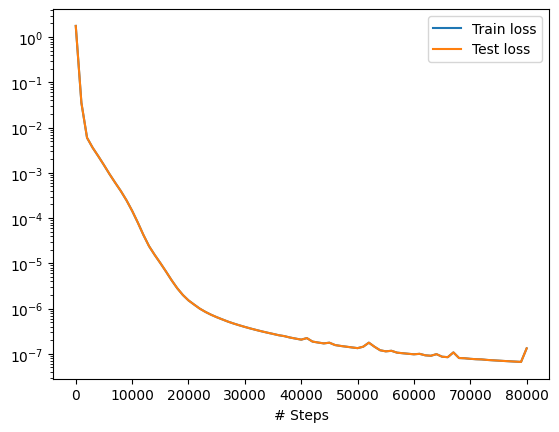

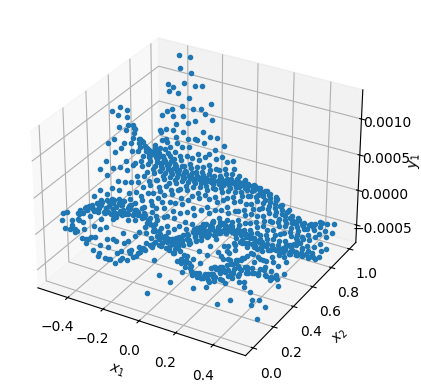

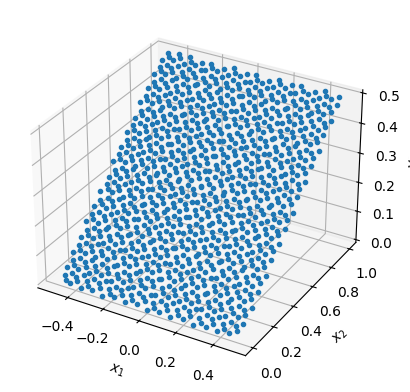

In [78]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import numpy as np
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# Constants
traction = 1
E = 2  # units
L = 1  # mm
nu = 0.003

# Geometry
geom = dde.geometry.Rectangle([-L/2, 0], [L/2, L])

# Analytical Solution Functions
def analytical_u_x(x):
    return -nu * traction / E * x[:, 0:1] * x[:, 1:2]/L

def analytical_u_y(x):
    return traction / E * x[:, 1:2]

# PDE Residual Function
def pde(x, y):
    u_y_pred = y[:, 1:2]
    u_x_pred = y[:, 0:1]
    u_y_analytical = analytical_u_y(x)
    u_x_analytical = analytical_u_x(x)
    res_u_y = u_y_pred - u_y_analytical
    res_u_x = u_x_pred - u_x_analytical

    return [res_u_x, res_u_y]

# Data Object
data = dde.data.PDE(
    geom,
    pde,
    [],
    num_domain=1000
)

# Neural Network
net = dde.maps.FNN([2] + [32] * 4 + [2], "tanh", "Glorot uniform")

# Model
model = dde.Model(data, net)

# Compile the Model
model.compile("adam", lr=1e-5)

# Train the Model
losshistory, train_state = model.train(epochs=80000, display_every=1000)

# Plot and Save Results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [57]:
Test = model.predict([[0,1]])
print(Test)

[[7.4416625e-05 4.9967405e-01]]


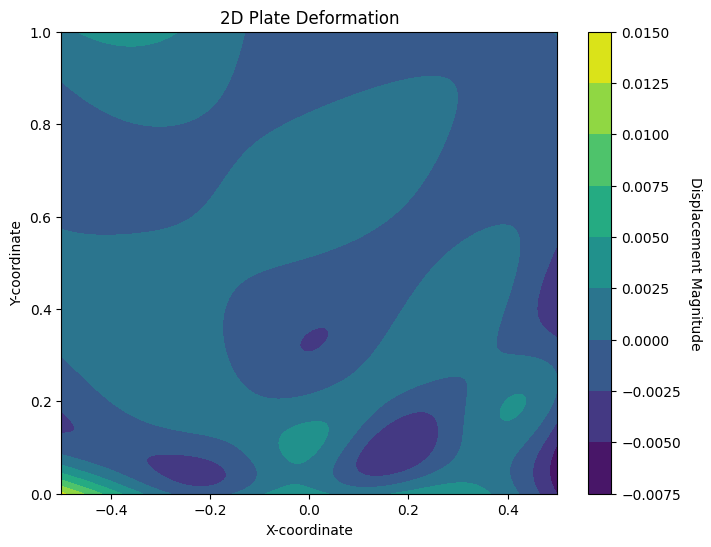

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model has already been trained
# Now you can generate test points in the geometry and evaluate the solution

# Generate a grid of points in the geometry (replace this with your actual grid)
x_test = np.linspace(-L/2, L/2, 3000)  # x-coordinates
y_test = np.linspace(0, L, 3000)  # y-coordinates
x_grid, y_grid = np.meshgrid(x_test, y_test)  # Create a mesh grid

# Flatten the grid points into a list of coordinates
test_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Predict displacements using the trained model
u_pred = model.predict(test_points)

# Extract the x and y displacements from the predictions
u_x_pred = u_pred[:, 0].reshape(x_grid.shape)
u_y_pred = u_pred[:, 1].reshape(y_grid.shape)

# Compute the magnitude of the deformation at each point
deformation_magnitude =  u_x_pred

# Plotting the 2D deformation with magnitude

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Plot the displacement magnitude as a contour plot
contour = plt.contourf(x_grid, y_grid, deformation_magnitude, cmap='viridis')

# Add a color bar to show the magnitude of displacement
cbar = plt.colorbar(contour)
cbar.set_label('Displacement Magnitude', rotation=270, labelpad=15)

# Overlay a quiver plot for displacement vectors
#plt.quiver(x_grid, y_grid, u_x_pred, u_y_pred, color='red', scale=1e-2, headwidth=3)

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('2D Plate Deformation')

# Show the plot
plt.show()
